<a href="https://colab.research.google.com/github/mori8/NLP-Pytorch-practice/blob/main/pytorch_lecture/Chapter_11_Advanced_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1x1 Convolution

일정 크기의 영역의 특성을 추출하기 위해 필터를 사용한다고 배웠는데, 굳이 1x1 크기의 필터를 사용하는 이유에 대해 의문이 들 수도 있겠다.
1x1 convolution을 사용하는 이유는 1x1x(filter 개수) shape의 필터를 통해 이미지의 width와 height를 그대로 두면서 **channel 수를 조절**할 수 있기 때문이다. channel 수의 감소로 파라미터의 수가 줄면서 **계산량을 감소**시킬 수 있다.


예를 들어, 28x28x192 크기의 입력이 들어왔을 때 5x5x32 크기의 필터로 특성 맵을 만들게 된다면 5 x 5 x 28 x 28 x 192 x 32 = 120,422,400개의 파라미터를 갖게 된다. 반면에 1x1x16 크기의 필터를 한 번 거친 뒤 5x5x32 크기의 필터를 거치게 되면 1 x 1 x 16 x 28 x 28 x 192 + 5 x 5 x 28 x 28 x 16 x 32 = 12,443,648개의 파라미터를 갖는다. 여기서 만들어지는 특성맵의 크기는 1x1 필터 덕분에 앞서 계산한 특성맵의 크기와 똑같으면서도 더 적은 수의 파라미터를 갖게 된다. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Inception Module from GoogleNet

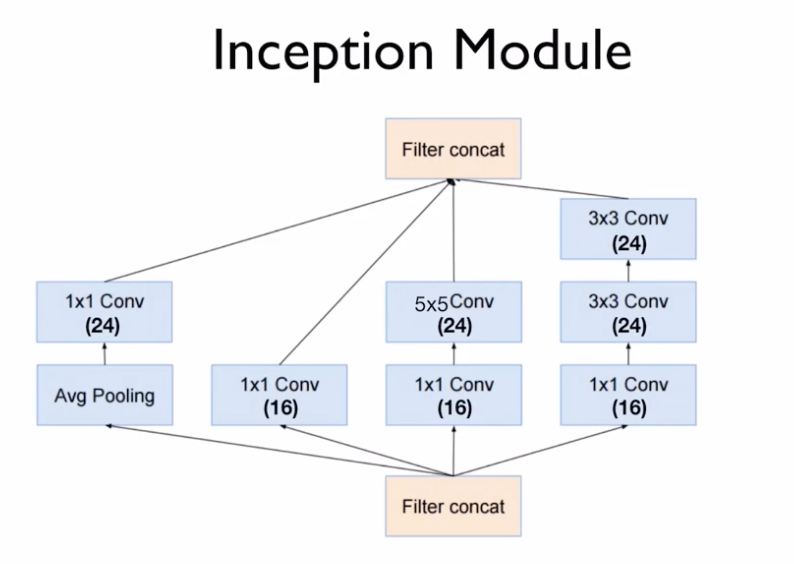

In [2]:
class InceptionA(nn.Module):
  def __init__(self, in_channels):
    super(InceptionA, self).__init__()
    
    self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    
    self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
    
    self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


  def forward(self, x):
    branch1x1 = self.branch1x1(x)

    branch5x5 = self.branch5x5_1(x)
    branch5x5 = self.branch5x5_2(branch5x5)

    branch3x3dbl = self.branch3x3dbl_1(x)
    branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
    branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

    branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    branch_pool = self.branch_pool(branch_pool)

    outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(88, 20, kernel_size=5)

    self.incept1 = InceptionA(in_channels=10)
    self.incept2 = InceptionA(in_channels=20)

    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(1408, 10)
  
  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = self.incept1(x)
    x = F.relu(self.mp(self.conv2(x)))
    x = self.incept2(x)
    x = x.view(in_size, -1)
    x = self.fc(x)

    return F.log_softmax(x)